# How to work with Hybrid gridded demographic data for the world, 1950-2020, on Earth Data Hub

Earth Data Hub (EDH) provides an innovative access to earth related data. This notebook will provide you guidance on how to access and use the https://hedp-data.bopen.eu/public/derived-GPWv4-Histsoc/demographics-hybrid-1950-2020-15-min-v0 dataset on Earth Data Hub.


This dataset combines the NASA SEDAC Gridded Population of the World version 4 (GPWv4) with the ISIMIP Histsoc gridded population data and the United Nations World Population Program (WPP) demographic modelling data. The data is supplied in 5-years population bands with 0.25° spatial resolution. For pre-2000 population data, the ISIMIP Histsoc data was upscaled from it's native 0.5˚ resolution to  0.25° resolution. The dataset grid is explicitly designed to match with the one of ERA5 single levels climate reanalysis dataset. 

### Goal of this tutorial

In this tutorial our goal is to compute and visualize the European population distribution in 2020.

### What you will learn:
* how to access and preview the data
* select and reduce the data
* plot the results

### Working with EDH data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data tipically looks like this:
1. data access and preview
2. data selection
3. (optional) data download 
4. (optional) data reduction
5. further operations and visualization

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place, e.g., when the `.compute()` or `.plot()` methods are called.

#### 1. Data access and preview

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically when you access a Zarr dataset:

In [1]:
import xarray as xr

ds = xr.open_dataset(
    "https://hedp-data.bopen.eu/public/derived-GPWv4-Histsoc/demographics-hybrid-1950-2020-15-min-v0",
    chunks={},
    engine="zarr",
)
ds

<xarray.Dataset> Size: 4GB
Dimensions:               (age_band_lower_bound: 14, latitude: 720,
                           longitude: 1440, year: 71)
Coordinates:
  * age_band_lower_bound  (age_band_lower_bound) int64 112B 0 5 10 ... 55 60 65
  * latitude              (latitude) float64 6kB 90.0 89.75 ... -89.5 -89.75
  * longitude             (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * year                  (year) int64 568B 1950 1951 1952 ... 2018 2019 2020
Data variables:
    demographic_totals    (latitude, longitude, age_band_lower_bound, year) float32 4GB dask.array<chunksize=(64, 64, 14, 71), meta=np.ndarray>

The longitude of the dataset is set from 0 to 360 degrees, which makes it uncomfortable to deal with data in the European area when using xarray:

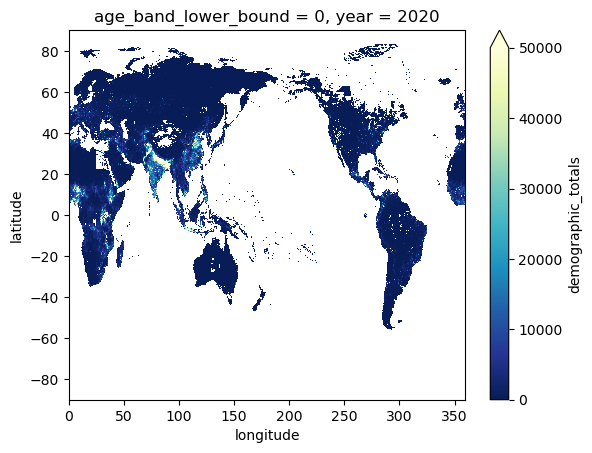

In [2]:
ds.demographic_totals.sel(age_band_lower_bound=0, year=2020).plot(vmax=50_000, cmap="YlGnBu_r")

we can roll longitude to a -180 to 180 extent:

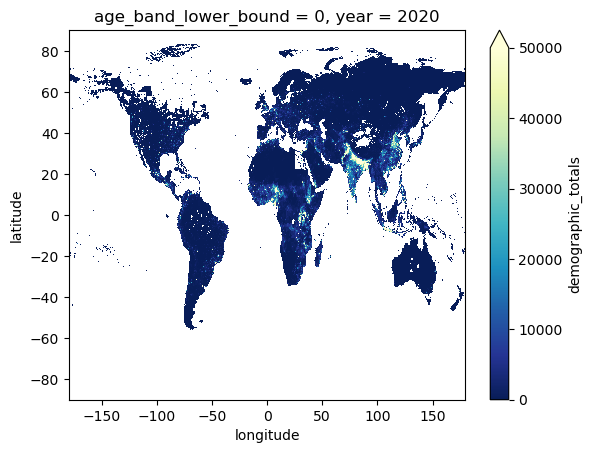

In [3]:
ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
ds = ds.roll(longitude=int(len(ds.longitude) / 2), roll_coords=True)
ds.demographic_totals.sel(age_band_lower_bound=0, year=2020).plot(vmax=50_000, cmap="YlGnBu_r")

#### 2. Data selection

First, we perform a geographical selection corresponding to the European area:

In [4]:
europe = ds.sel(latitude=slice(70, 35), longitude=slice(-10,41))

Next, we select year 2020

In [5]:
europe_2020 = europe.sel(year = 2020)

This sequence of selections greatly reduces the amount of data that will be downloaded. 
For the moment, the bahaviour is still lazy.

#### 3. Data reduction
For the selected year, we compute the sum of all population bands:

In [6]:
europe_total_population_2020 = europe_2020.sum("age_band_lower_bound")

this can be easily computed (computation will also trigger the dowload):

In [7]:
%%time

europe_total_population_2020.compute();

CPU times: user 840 ms, sys: 195 ms, total: 1.04 s
Wall time: 846 ms


### 3. Visualization

Finally, we can easily plot the total population in Europe for the year 2020:

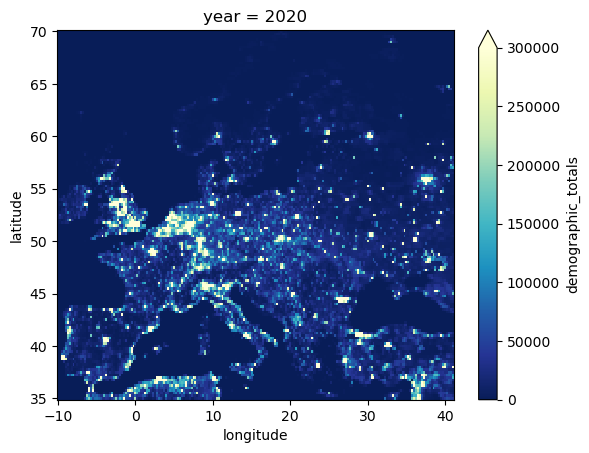

In [8]:
europe_total_population_2020.demographic_totals.plot(vmax=300_000, cmap="YlGnBu_r")